In [0]:
"""Beer fermentation sensitivity analysis - 30L Baseline (No Scaling)."""


'Beer fermentation sensitivity analysis - 30L Baseline (No Scaling).'

In [0]:

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import os


In [0]:


class BeerFermentationModel:
    """Beer fermentation model based on biomass dynamics (Section 3.4.1)."""
    
    def __init__(self, params):
        self.params = params
    
    def calculate_specific_growth_rate(self, sugar, s_min, mu_max):
        if sugar >= s_min:
            return mu_max * (1 - s_min / sugar)
        else:
            return 0.0
    
    def temperature_dependency(self, temperature):
        params = self.params
        mu_max = params['a'] * np.log(temperature) + params['b']
        r_vdk = params['c'] * np.log(temperature) + params['d']
        return mu_max, r_vdk
    
    def derivatives(self, state, time_point, temperature):
        biomass, sugar, ethanol, co2, vdk = state
        params = self.params
        
        mu_max, r_vdk = self.temperature_dependency(temperature)
        mu_x = self.calculate_specific_growth_rate(sugar, params['S_min'], 
                                                   mu_max)
        
        dx_dt = mu_x * biomass - params['delta_x'] * biomass
        ds_dt = -params['k_s'] * mu_x * biomass
        de_dt = params['k_e'] * mu_x * biomass
        dco2_dt = params['k_co2'] * mu_x * biomass
        dvdk_dt = params['k_v'] * mu_x * biomass - r_vdk * vdk
        
        return [dx_dt, ds_dt, de_dt, dco2_dt, dvdk_dt]
    
    def simulate(self, initial_state, time_span, temperature):
        solution = odeint(self.derivatives, initial_state, time_span, 
                         args=(temperature,))
        return solution



In [0]:
def get_base_parameters():
    """Get base parameters from Table 5 (30L fermenter)."""
    return {
        'k_s': 15.3,
        'k_e': 6.31,
        'k_co2': 37.1,
        'k_v': 0.651,
        'S_min': 13.1,
        'delta_x': 0.0167,
        'a': 0.400,
        'b': -1.1,
        'c': 0.0250,
        'd': -0.0560,
    }


In [0]:



def sensitivity_analysis_30L(temperatures, sugar_concentrations, 
                             initial_biomass=0.529, duration=72):
    """
    Perform sensitivity analysis on 30L baseline fermenter.
    
    Args:
        temperatures: List of temperatures to test (°C)
        sugar_concentrations: List of initial sugar values (g/L)
        initial_biomass: Initial yeast concentration (g/L)
        duration: Simulation duration (hours)
    
    Returns:
        DataFrame with results for all combinations
    """
    
    # Fixed 30L parameters (no scaling)
    params = get_base_parameters()
    volume = 3500.0  # L (fixed)
    
    # Storage for results
    results_list = []
    
    # Run simulations for all combinations
    total_sims = len(temperatures) * len(sugar_concentrations)
    sim_count = 0
    
    print(f"Running {total_sims} simulations on 30L baseline fermenter...")
    
    for temp in temperatures:
        for s0_test in sugar_concentrations:
            sim_count += 1
            
            # Initial conditions
            x0 = initial_biomass
            s0 = s0_test
            e0 = 0.0
            co2_0 = 0.0
            vdk0 = 0.0
            
            initial_state = [x0, s0, e0, co2_0, vdk0]
            
            # Time points
            time_points = np.linspace(0, duration, 300)
            
            # Run simulation
            model = BeerFermentationModel(params)
            solution = model.simulate(initial_state, time_points, temp)
            
            # Extract final results
            x_final, s_final, e_final, co2_final, vdk_final = solution[-1]
            
            # Calculate metrics
            sugar_consumed = s0 - s_final
            sugar_consumed_pct = (sugar_consumed / s0) * 100
            abv = (e_final * 0.789 / 10)
            biomass_yield = x_final - x0
            
            # Store results
            results_list.append({
                'Temperature (°C)': temp,
                'Initial Sugar (g/L)': s0,
                'Final Biomass (g/L)': x_final,
                'Final Sugar (g/L)': s_final,
                'Final Ethanol (g/L)': e_final,
                'Final CO2 (L)': co2_final,
                'Final VDK (ppm)': vdk_final,
                'Sugar Consumed (g/L)': sugar_consumed,
                'Sugar Consumed (%)': sugar_consumed_pct,
                'Est. ABV (%)': abv,
                'Biomass Yield (g/L)': biomass_yield,
                'Ethanol Yield (g/g sugar)': e_final / sugar_consumed if sugar_consumed > 0 else 0,
                'Total Biomass (g)': x_final * volume,
                'Total Ethanol (g)': e_final * volume
            })
            
            print(f"[{sim_count}/{total_sims}] T={temp}°C, S0={s0_test} g/L → "
                  f"ABV={abv:.1f}%, Sugar consumed={sugar_consumed_pct:.1f}%")
    
    print("✓ Sensitivity analysis complete!")
    
    # Create DataFrame
    sensitivity_df = pd.DataFrame(results_list)
    
    return sensitivity_df


In [0]:


def plot_sensitivity_heatmaps(sensitivity_df, save_path=None):
    """
    Create heatmap visualizations of sensitivity analysis.
    
    Args:
        sensitivity_df: DataFrame from sensitivity_analysis_30L()
        save_path: Path to save plots (optional)
    """
    
    # Get unique values
    temps = sorted(sensitivity_df['Temperature (°C)'].unique())
    sugars = sorted(sensitivity_df['Initial Sugar (g/L)'].unique())
    
    # Create figure with 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Sensitivity Analysis: 30L Baseline Fermenter\nTemperature vs Initial Sugar', 
                 fontsize=16, fontweight='bold')
    
    # Metrics to plot
    metrics = [
        ('Final Ethanol (g/L)', 'Ethanol Production', 'YlOrRd'),
        ('Est. ABV (%)', 'Alcohol by Volume', 'RdPu'),
        ('Sugar Consumed (%)', 'Sugar Consumption', 'YlGnBu'),
        ('Final VDK (ppm)', 'VDK Levels', 'YlOrBr')
    ]
    
    for idx, (metric, title, cmap) in enumerate(metrics):
        ax = axes[idx // 2, idx % 2]
        
        # Pivot data
        pivot = sensitivity_df.pivot(
            index='Temperature (°C)', 
            columns='Initial Sugar (g/L)', 
            values=metric
        )
        
        # Create heatmap
        im = ax.imshow(pivot, cmap=cmap, aspect='auto')
        
        # Labels
        ax.set_xticks(np.arange(len(sugars)))
        ax.set_yticks(np.arange(len(temps)))
        ax.set_xticklabels(sugars)
        ax.set_yticklabels(temps)
        ax.set_xlabel('Initial Sugar (g/L)', fontsize=11)
        ax.set_ylabel('Temperature (°C)', fontsize=11)
        ax.set_title(title, fontsize=12, fontweight='bold')
        
        # Colorbar
        cbar = plt.colorbar(im, ax=ax)
        cbar.ax.tick_params(labelsize=9)
        
        # Annotate values
        for i in range(len(temps)):
            for j in range(len(sugars)):
                value = pivot.iloc[i, j]
                text = ax.text(j, i, f'{value:.1f}',
                             ha="center", va="center", 
                             color="black", fontsize=8)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        filepath = os.path.join(save_path, 'sensitivity_heatmaps_30L.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"✓ Heatmaps saved to: {filepath}")
        
        pdf_path = filepath.replace('.png', '.pdf')
        plt.savefig(pdf_path, bbox_inches='tight')
        print(f"✓ PDF saved to: {pdf_path}")
    
    plt.show()



In [0]:

def plot_sensitivity_curves(sensitivity_df, save_path=None):
    """
    Create line plots showing trends.
    
    Args:
        sensitivity_df: DataFrame from sensitivity_analysis_30L()
        save_path: Path to save plots (optional)
    """
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Sensitivity Analysis: 30L Baseline Fermenter\nTrend Curves', 
                 fontsize=16, fontweight='bold')
    
    temps = sorted(sensitivity_df['Temperature (°C)'].unique())
    sugars = sorted(sensitivity_df['Initial Sugar (g/L)'].unique())
    
    # Plot 1: Ethanol vs Temperature (different sugar levels)
    ax = axes[0, 0]
    for sugar in sugars:
        subset = sensitivity_df[sensitivity_df['Initial Sugar (g/L)'] == sugar]
        ax.plot(subset['Temperature (°C)'], subset['Final Ethanol (g/L)'], 
               marker='o', label=f'{sugar} g/L sugar', linewidth=2)
    ax.set_xlabel('Temperature (°C)', fontsize=11)
    ax.set_ylabel('Final Ethanol (g/L)', fontsize=11)
    ax.set_title('Ethanol Production vs Temperature', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: ABV vs Initial Sugar (different temperatures)
    ax = axes[0, 1]
    for temp in temps:
        subset = sensitivity_df[sensitivity_df['Temperature (°C)'] == temp]
        ax.plot(subset['Initial Sugar (g/L)'], subset['Est. ABV (%)'], 
               marker='s', label=f'{temp}°C', linewidth=2)
    ax.set_xlabel('Initial Sugar (g/L)', fontsize=11)
    ax.set_ylabel('ABV (%)', fontsize=11)
    ax.set_title('ABV vs Initial Sugar', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Sugar Consumption vs Temperature
    ax = axes[1, 0]
    for sugar in sugars:
        subset = sensitivity_df[sensitivity_df['Initial Sugar (g/L)'] == sugar]
        ax.plot(subset['Temperature (°C)'], subset['Sugar Consumed (%)'], 
               marker='o', label=f'{sugar} g/L sugar', linewidth=2)
    ax.set_xlabel('Temperature (°C)', fontsize=11)
    ax.set_ylabel('Sugar Consumed (%)', fontsize=11)
    ax.set_title('Sugar Consumption vs Temperature', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: VDK vs Temperature
    ax = axes[1, 1]
    for sugar in sugars:
        subset = sensitivity_df[sensitivity_df['Initial Sugar (g/L)'] == sugar]
        ax.plot(subset['Temperature (°C)'], subset['Final VDK (ppm)'], 
               marker='o', label=f'{sugar} g/L sugar', linewidth=2)
    ax.set_xlabel('Temperature (°C)', fontsize=11)
    ax.set_ylabel('Final VDK (ppm)', fontsize=11)
    ax.set_title('VDK Levels vs Temperature', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        filepath = os.path.join(save_path, 'sensitivity_curves_30L.png')
        plt.savefig(filepath, dpi=300, bbox_inches='tight')
        print(f"✓ Curves saved to: {filepath}")
        
        pdf_path = filepath.replace('.png', '.pdf')
        plt.savefig(pdf_path, bbox_inches='tight')
        print(f"✓ PDF saved to: {pdf_path}")
    
    plt.show()



Running 9 simulations on 30L baseline fermenter...
[1/9] T=17°C, S0=99.89 g/L → ABV=2.8%, Sugar consumed=86.9%
[2/9] T=17°C, S0=124.84 g/L → ABV=3.6%, Sugar consumed=89.5%
[3/9] T=17°C, S0=149.81 g/L → ABV=4.4%, Sugar consumed=91.3%
[4/9] T=19°C, S0=99.89 g/L → ABV=2.8%, Sugar consumed=86.9%
[5/9] T=19°C, S0=124.84 g/L → ABV=3.6%, Sugar consumed=89.5%
[6/9] T=19°C, S0=149.81 g/L → ABV=4.4%, Sugar consumed=91.3%
[7/9] T=21°C, S0=99.89 g/L → ABV=2.8%, Sugar consumed=86.9%
[8/9] T=21°C, S0=124.84 g/L → ABV=3.6%, Sugar consumed=89.5%
[9/9] T=21°C, S0=149.81 g/L → ABV=4.4%, Sugar consumed=91.3%
✓ Sensitivity analysis complete!
SENSITIVITY ANALYSIS RESULTS (30L Baseline)


Temperature (°C),Initial Sugar (g/L),Final Biomass (g/L),Final Sugar (g/L),Final Ethanol (g/L),Final CO2 (L),Final VDK (ppm),Sugar Consumed (g/L),Sugar Consumed (%),Est. ABV (%),Biomass Yield (g/L),Ethanol Yield (g/g sugar),Total Biomass (g),Total Ethanol (g)
17,99.89,2.4022677046614374,13.10098529493614,35.79337796006227,210.4491794482266,1.1715009286423157,86.78901470506386,86.88458775159062,2.8240975210489134,-2.0647322953385623,0.41241830065359464,8407.93696631503,125276.82286021796
17,124.84,2.98444467848024,13.100742011276173,46.08331489600309,270.94944257396475,1.5959844528673746,111.73925798872384,89.50597403774738,3.635973545294644,-1.4825553215197598,0.4124183006535947,10445.55637468084,161291.6021360108
17,149.81,3.626312076088457,13.100609262510778,56.38145461134356,331.49793440266996,2.058921065736344,136.70939073748923,91.25518372437703,4.448496768835007,-0.8406879239115428,0.41241830065359447,12692.092266309599,197335.09113970245
19,99.89,2.0678273339267204,13.100000000225403,35.79378431363252,210.4515686269045,0.7348578163625928,86.7899999997746,86.88557413131905,2.824129582345606,-2.3991726660732793,0.4124183006535947,7237.395668743521,125278.24509771382
19,124.84,2.454734845780098,13.100000000254072,46.08362091492791,270.9512418294491,0.9677560875759014,111.73999999974593,89.50656840735817,3.635997690187813,-2.0122651542199015,0.4124183006535949,8591.571960230343,161292.6732022477
19,149.81,2.8546011891285388,13.099999999860525,56.381705882410486,331.49941176504393,1.2088777843789964,136.71000000013947,91.25559041461815,4.448516594122188,-1.6123988108714609,0.41241830065359497,9991.104161949886,197335.9705884367
21,99.89,2.0077306399753416,13.09999999310767,35.793784316567965,210.451568644164,0.5499989084271886,86.79000000689233,86.88557413844462,2.824129582577213,-2.459269360024658,0.41241830065359425,7027.057239913695,125278.24510798788
21,124.84,2.3634453023212063,13.099999992902347,46.08362091795978,270.95124184727547,0.7196806101005997,111.74000000709765,89.50656841324708,3.635997690427027,-2.1035546976787933,0.41241830065359386,8272.058558124221,161292.67321285923
21,149.81,2.7266754394410655,13.099999992181646,56.38170588557734,331.499411783664,0.8936612649616464,136.71000000781837,91.25559041974391,4.448516594372053,-1.7403245605589341,0.41241830065359447,9543.36403804373,197335.9705995207



✓ Results saved to: tmp/plots/sensitivity_30L/sensitivity_analysis_30L.csv
GENERATING VISUALIZATIONS
✓ Heatmaps saved to: tmp/plots/sensitivity_30L/sensitivity_heatmaps_30L.png
✓ PDF saved to: tmp/plots/sensitivity_30L/sensitivity_heatmaps_30L.pdf


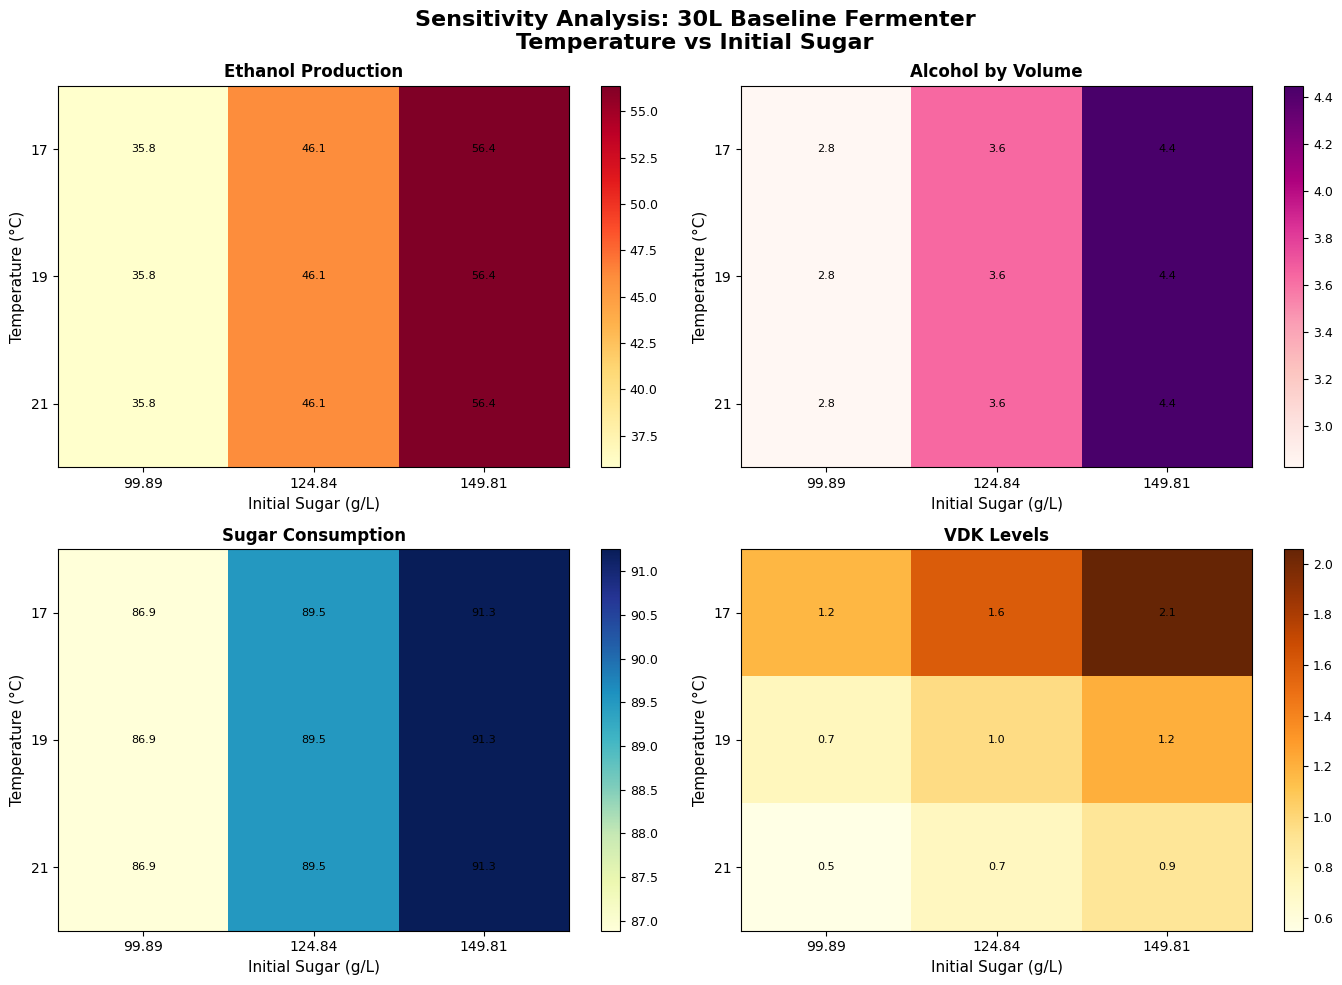

✓ Curves saved to: tmp/plots/sensitivity_30L/sensitivity_curves_30L.png
✓ PDF saved to: tmp/plots/sensitivity_30L/sensitivity_curves_30L.pdf


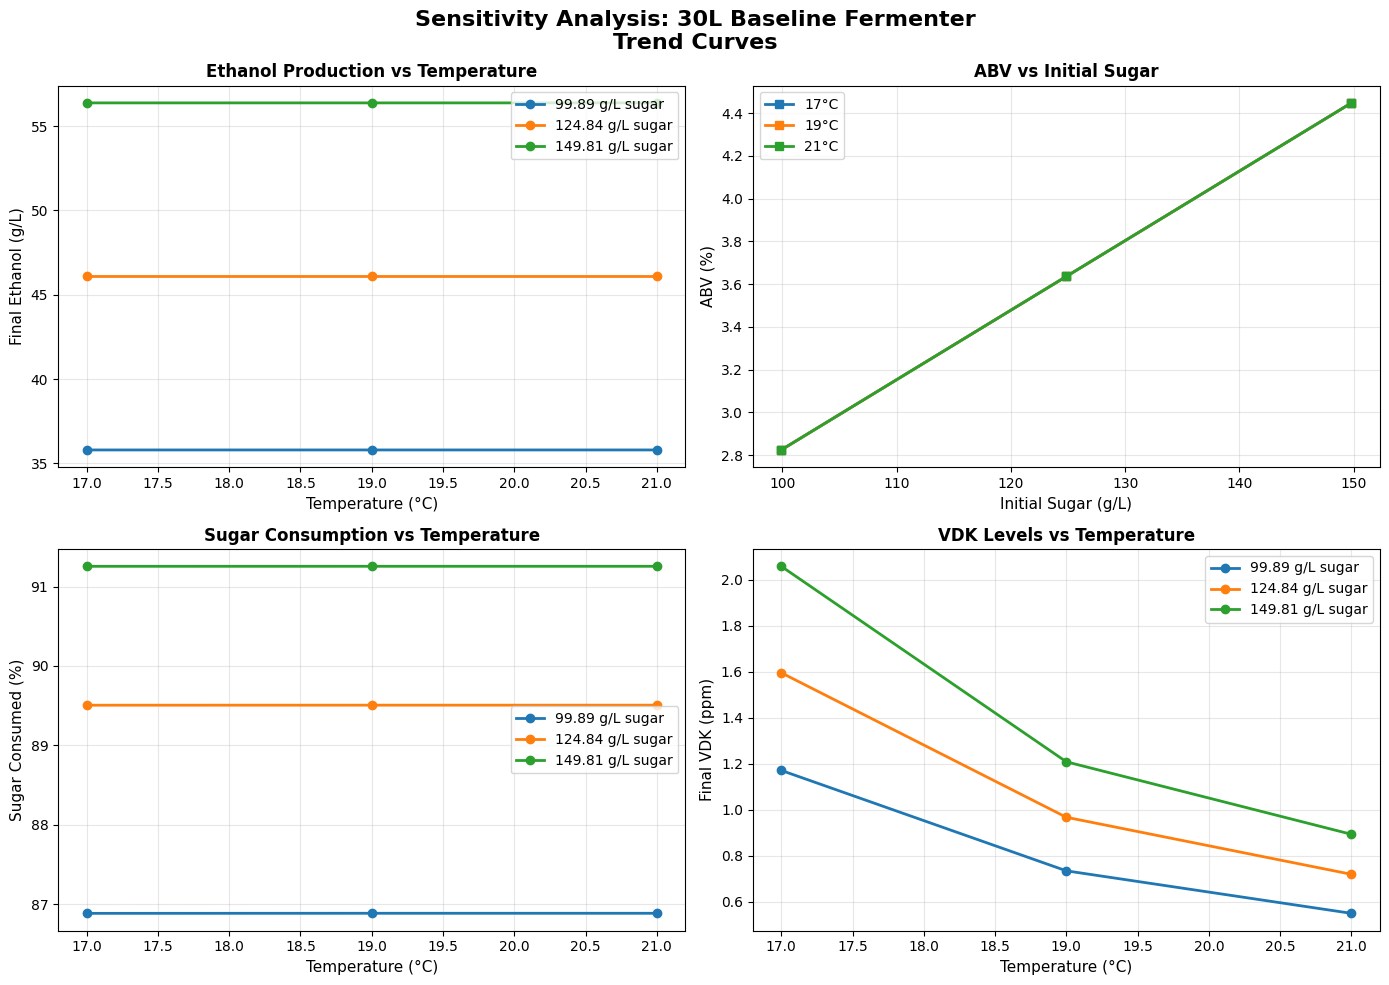

SUMMARY STATISTICS BY TEMPERATURE


"('Est. ABV (%)', 'min')","('Est. ABV (%)', 'max')","('Est. ABV (%)', 'mean')","('Sugar Consumed (%)', 'min')","('Sugar Consumed (%)', 'max')","('Sugar Consumed (%)', 'mean')","('Final VDK (ppm)', 'min')","('Final VDK (ppm)', 'max')","('Final VDK (ppm)', 'mean')"
2.82,4.45,3.64,86.88,91.26,89.22,1.17,2.06,1.61
2.82,4.45,3.64,86.89,91.26,89.22,0.73,1.21,0.97
2.82,4.45,3.64,86.89,91.26,89.22,0.55,0.89,0.72


SUMMARY STATISTICS BY INITIAL SUGAR


"('Est. ABV (%)', 'min')","('Est. ABV (%)', 'max')","('Est. ABV (%)', 'mean')","('Sugar Consumed (%)', 'min')","('Sugar Consumed (%)', 'max')","('Sugar Consumed (%)', 'mean')","('Final VDK (ppm)', 'min')","('Final VDK (ppm)', 'max')","('Final VDK (ppm)', 'mean')"
2.82,2.82,2.82,86.88,86.89,86.89,0.55,1.17,0.82
3.64,3.64,3.64,89.51,89.51,89.51,0.72,1.6,1.09
4.45,4.45,4.45,91.26,91.26,91.26,0.89,2.06,1.39


ANALYSIS COMPLETE
Fermenter Volume: 30L (baseline)
Total simulations run: 9
Files saved in: tmp/plots/sensitivity_30L/

Generated files:
  - sensitivity_analysis_30L.csv
  - sensitivity_heatmaps_30L.png/.pdf
  - sensitivity_curves_30L.png/.pdf


In [0]:

if __name__ == "__main__":
    
    # ========================================================================
    # CONFIGURE SENSITIVITY ANALYSIS (30L BASELINE)
    # ========================================================================
    
    # Temperature range (°C) - from Table 2
    temperatures = [17, 19, 21]
    
    # Initial sugar concentrations (g/L) - realistic brewing range
    sugar_concentrations = [99.89, 124.84, 149.81,]
    
    # Other parameters
    initial_biomass = 4.467    # g/L (from Table 2, Experiment 2)
    duration = 100              # hours
    
    # Save path
    save_path = "tmp/plots/sensitivity_30L"
    
    # ========================================================================
    # RUN SENSITIVITY ANALYSIS
    # ========================================================================
    
    sensitivity_results = sensitivity_analysis_30L(
        temperatures=temperatures,
        sugar_concentrations=sugar_concentrations,
        initial_biomass=initial_biomass,
        duration=duration
    )
    
    # ========================================================================
    # DISPLAY RESULTS
    # ========================================================================
    
    print("SENSITIVITY ANALYSIS RESULTS (30L Baseline)")
    display(sensitivity_results)
    
    # ========================================================================
    # SAVE RESULTS
    # ========================================================================
    
    os.makedirs(save_path, exist_ok=True)
    csv_path = os.path.join(save_path, 'sensitivity_analysis_30L.csv')
    sensitivity_results.to_csv(csv_path, index=False)
    print(f"\n✓ Results saved to: {csv_path}")
    
    # CREATE VISUALIZATIONS
    
    print("GENERATING VISUALIZATIONS")
    
    # Heatmaps
    plot_sensitivity_heatmaps(sensitivity_results, save_path=save_path)
    
    # Trend curves
    plot_sensitivity_curves(sensitivity_results, save_path=save_path)
    
    # SUMMARY STATISTICS
    
    print("SUMMARY STATISTICS BY TEMPERATURE")
    
    summary_by_temp = sensitivity_results.groupby('Temperature (°C)').agg({
        'Est. ABV (%)': ['min', 'max', 'mean'],
        'Sugar Consumed (%)': ['min', 'max', 'mean'],
        'Final VDK (ppm)': ['min', 'max', 'mean']
    }).round(2)
    
    display(summary_by_temp)
    
    print("SUMMARY STATISTICS BY INITIAL SUGAR")
    
    summary_by_sugar = sensitivity_results.groupby('Initial Sugar (g/L)').agg({
        'Est. ABV (%)': ['min', 'max', 'mean'],
        'Sugar Consumed (%)': ['min', 'max', 'mean'],
        'Final VDK (ppm)': ['min', 'max', 'mean']
    }).round(2)
    
    display(summary_by_sugar)
    
    print("ANALYSIS COMPLETE")
    print(f"Fermenter Volume: 30L (baseline)")
    print(f"Total simulations run: {len(sensitivity_results)}")
    print(f"Files saved in: {save_path}/")
    print("\nGenerated files:")
    print("  - sensitivity_analysis_30L.csv")
    print("  - sensitivity_heatmaps_30L.png/.pdf")
    print("  - sensitivity_curves_30L.png/.pdf")